# Traveling Salesman Problem Solved Using Genetic Algorithms

The TSP is an old proverbial problem. A salesman with $K$ stopping points wants to find the most efficient route. The TSP essentially boils down to a combinatorial problem. We'd like to see every combination of solutions and choose the best. However, due to the nature of $K$ being usually large, testing every combination of possible routes can be very, very taxing in time and resources. 

There exist many articles discussing solutions to this problem:

- https://simple.wikipedia.org/wiki/Travelling_salesman_problem

- http://toddwschneider.com/posts/traveling-salesman-with-simulated-annealing-r-and-shiny/

- http://www.theprojectspot.com/tutorial-post/simulated-annealing-algorithm-for-beginners/6



In [1]:
import itertools as it
from tqdm import tqdm
import math

In [2]:

K = 15
print('Number of potential solutions', math.factorial(15))
points = list(range(K))
print(points)
#permutations = it.permutations(points, r = K)
#sum([1 for _ in tqdm(permutations)]) # 1,307,674,368,000

Number of potential solutions 1307674368000
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


## Greedy Search

Generally, greedy search algorithm lead to a good-enough solution, but not the best. An approach would be, for points $(x_1, y_1), ..., (x_k, y_k)$


- Find a starting point $(x_0, y_0)$

- For 1:K, 

    - find the closest point to you, $(x_j, y_j)$ and choose that to be the next stop in your path

- After the last stop, travel back to your starting point $(x_0, y_0)$.

This is a simple algorithm, and can lead to a "good-enough" solution, but a much better solution may exist.


## Genetic Algorithm

The algorithm we will follow is simple. Given a `fitness function`, $f(\cdot)$ we are trying to maximize, and for a certain number of generations, $N$, do the following

1. Initialize the population with randomly shuffled ordered paths; `parents`

2. Calculate the distance for each path in the population, then use this as the fitness function you are trying to minimize

    1. (Optional) Keep track of the fittest individual(s) throughout all generations

3. Sample the `parents` with sampling weights based on fitness (i.e. those with greater fitness have greater likelihood of being resampled); these will be used to create `children` for the next generation

    4. With some `mutation rate` mutate the `parents`

    5. (Optional) With some `crossover rate` select pairs of `parents` and randomly combine characteristics

4. The population from steps 4-5 become the `children` from the previous generation. Repeate steps 1-7.


### Suggestions for rearranging the path

One option is to choose two random points in the path (e.g. 2nd and 3rd points) and switch them, but a better approach is to select larger sections of the path and reverse the order such as

- e.g. path: 1,2,3,4,5,6,7,8,9,10 --> [4,3,2,1],5,6,7,8,9,10


### References:

P. Larrañaga, C. M. H. Kuijpers, R. H. Murga, I. Inza, and S. Dizdarevic. 1999. Genetic Algorithms for the Travelling Salesman Problem: A Review of Representations and Operators. Artif. Intell. Rev. 13, 2 (April 1999), 129-170. DOI: https://doi.org/10.1023/A:1006529012972

["Genetic Algorithms for the Traveling Salesman Problem"](https://www.cs.indiana.edu/~vgucht/Genetic_Algorithms_for_the_Travelling_Salesman+Problem.pdf) (J.J. Grefenstette, R. Gopal, B.J. Rosmaita, D. Van Gucht). Proceedings of the 1st International Conference on Genetic Algorithms, 1985.

["Parallel Genetic Algorithms Applied to the Traveling Salesman Problem"](https://www.cs.indiana.edu/~vgucht/parallel-genetic-algorithms-traveling-salesman.TR314.pdf) (P. Jog, J.Y. Suh, D. Van Gucht) SIAM Journal on Optimization Vol. 1, No. 4, pages 515--529, 1991. Also published as IU Tech Report TR314.


Potvin, Jean-Yves. ["Genetic Algorithms for the Traveling Salesman Problem."](https://iccl.inf.tu-dresden.de/w/images/b/b7/GA_for_TSP.pdf) Annals of Operations Research 63, no. 3 (1996): 337-70.

## Set up

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
def gen_locations(seed=123, size=15):
    '''
    Generate (size=15) random locations
    '''
    np.random.seed(seed)
    x = np.random.randint(low = 1, high = 10+1, size = size)
    y = np.random.randint(low = 1, high = 10+1, size = size)
    return x,y


In [5]:
def distance(p1, p2):
    '''Returns Euclidean Distance between two points'''
    x1, y1 = p1
    x2, y2 = p2
    d = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    if d == 0:
        d = np.inf
    return d

In [6]:
def path_cost(path):
    start = path.pop() ## should be in order
    d = 0 # distance
    for p2 in reversed(path):
        d += distance(start, p2)
        print('{} --> {}: {}'.format(start, p2, round(d, 3)))
        start = p2
    return d

In [7]:
x,y = gen_locations(456,15) ## lowest distance 32.85
points = list(zip(x,y))

In [8]:
path_cost(points) # not accounting the trip back!

(5, 6) --> (9, 4): 4.472
(9, 4) --> (3, 4): 10.472
(3, 4) --> (3, 1): 13.472
(3, 1) --> (5, 1): 15.472
(5, 1) --> (3, 8): 22.752
(3, 8) --> (6, 7): 25.915
(6, 7) --> (4, 4): 29.52
(4, 4) --> (9, 3): 34.619
(9, 3) --> (2, 9): 43.839
(2, 9) --> (8, 10): 49.921
(8, 10) --> (6, 1): 59.141
(6, 1) --> (5, 7): 65.224
(5, 7) --> (10, 6): 70.323
(10, 6) --> (6, 9): 75.323


75.32272778228025

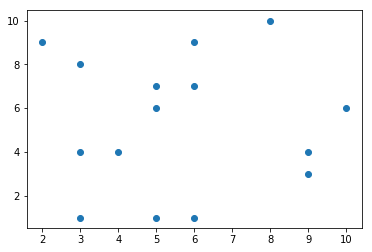

In [9]:
plt.scatter(x,y) ## lowest distance 32.85

The path class will represent one unit/individual in the population!

In [10]:
class Path:
    def __init__(self, points):
        self.points = points # genes
        self._create_path() # ordered set of points
    
    def __repr__(self):
        return 'Path Distance: {}'.format(round(self.distance, 3))
    
    def __len__(self):
        return len(self.points)
    
    def __getitem__(self, item):
        return self.points[item]
    
    def copy(self):
        return Path(points = self.points)
        
    def _create_path(self, return_=False):
        points = self.points.copy()
        _init = points.pop(0) # get first item as start
        p1 = tuple(_init) # make copy; it will be end as well
        path = [p1]
        d = 0 # initial distance
        for p2 in points:
            path.append(p2) # save the points
            d += distance(p1, p2) # update the distance
            p1 = p2 # update current location 
        path.append(_init) ## start == end
        d += distance(p1, _init)
        self.path = path
        self.distance = d
        
        if return_:
            return d, path # return distance and path
    
    def plot(self, i=''):
        x,y = list(zip(*self.points))
        plt.scatter(x, y, marker='x')
        a,b = list(zip(*self.path))
        plt.plot(a,b)
        plt.title('{} Distnace: {}'.format(i,round(self.distance, 3)))

In [11]:
x,y = gen_locations(456,15) ## lowest distance 32.85
points = list(zip(x,y))
p = Path(points)
print('Initial', p)

Initial Path Distance: 78.485


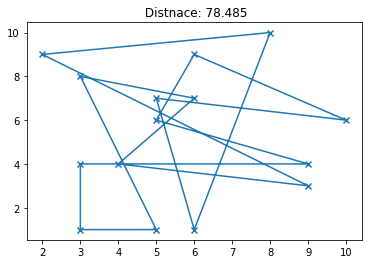

In [12]:
p.plot() # initial random potential route

## Greedy Search Attempt

In [13]:
class GreedySolve:
    def __init__(self, x, y):
        '''
        Greedy solution for Traveling Salesman Probmem
        
          The main idea behind a greedy algorithm is local optimization. 
          That is, the algorithm picks what seems to be the best thing to do at
          the particular time, instead of considering the global situation.
          Hence it is called "greedy" because a greedy person grabs anything 
          good he can at the particular time without considering the long-range 
          implications of his actions.
        '''
        self.x = x
        self.y = y
        self.path = None # (np.array, np.array)
    
    def plot(self):
        plt.scatter(self.x, self.y)
        if self.path:
            a,b = list(zip(*self.path))
            plt.plot(a,b)
            plt.title('Distnace: {}'.format(self.distance))

    def solve(self, return_=False):
        '''Greedy iterative solution to the TP problem from (0,0)'''
        points = list(zip(self.x, self.y))
        _init = points.pop() # choose a point to begin the path
        # starting point shouldn't matter since it's a hamiltonian graph
        start = tuple(_init) # copy
        d = 0
        path = [start]
        iters = range(len(points))
        for _ in tqdm(iters):
            dist, p2 = _return_closest(start, points)
            points.remove(p2)
            path.append(p2)
            d += dist
            start = p2
        d += distance(start, _init)
        path.append(_init)
        
        #print(path)
        self.path = path
        self.distance = round(d, 3)
        
        if return_:
            return round(d,3), path

        
def _return_closest(p1, candidates):
    distances = []
    for p2 in candidates:
        d = distance(p1, p2)
        distances.append((d, p2))
    distances.sort(key = lambda x: x[0], reverse=False)
    return distances[0] ## return (distance, p2)
    

100%|██████████| 14/14 [00:00<00:00, 11448.68it/s]


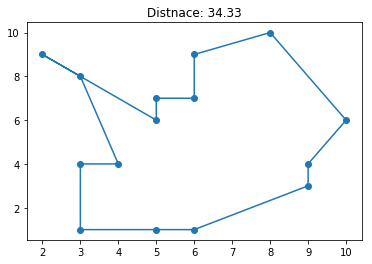

In [14]:
solution = GreedySolve(x, y)
solution.solve()
solution.plot()


In [15]:
path_cost(solution.path.copy())

(5, 6) --> (2, 9): 4.243
(2, 9) --> (3, 8): 5.657
(3, 8) --> (4, 4): 9.78
(4, 4) --> (3, 4): 10.78
(3, 4) --> (3, 1): 13.78
(3, 1) --> (5, 1): 15.78
(5, 1) --> (6, 1): 16.78
(6, 1) --> (9, 3): 20.386
(9, 3) --> (9, 4): 21.386
(9, 4) --> (10, 6): 23.622
(10, 6) --> (8, 10): 28.094
(8, 10) --> (6, 9): 30.33
(6, 9) --> (6, 7): 32.33
(6, 7) --> (5, 7): 33.33
(5, 7) --> (5, 6): 34.33


34.32978306057319

## GA Solution

The GASolve module takes in the `points` for each location we need to visit, the population size `n`, and the rate of mutation, `mutation_rate`. Then, after the object is created, we can solve the problem using the `solve` function, which takes a number of generations as an argument, `generations`.

The function evolves the population over time by using the `_mutation` function. This function takes in the current population, `parents` to spawn new children which will have varying characteristics determined by a `mutation_rate`.

The traveling salesperson problem is essentially a minimization problem, where we want to minimize the total distance traveled. Thus, we need to find a fitness function that will return values that favor a minimizing value. I've chosen to use 

$$
f(distance) = \frac{1}{distance^{4}}
$$

So each unit in the population gets a weight $w = f(distance)$, and `_mutate` normalizes these weights by dividing each weight by the sum of all weights. I used the specific function above because I wanted to heavily weight those units that performed well. Here are the snippets of code where this is used

    weights = np.array([1/np.exp(path.distance) for path in parents]) # we want a smaller distance
    weights = weights / weights.sum() # normalize weights



Text(0,0.5,'Weights')

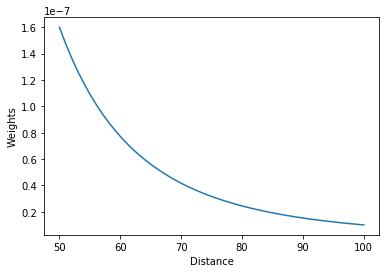

In [16]:
f = lambda x: 1 / (x**4)
x = np.linspace(50, 100) # distance
plt.plot(x, f(x))
plt.xlabel("Distance")
plt.ylabel("Weights")

In [17]:

class GASolve:
    def __init__(self, points, n = 100, mutation_rate=0.5):
        x, y = list(zip(*points))
        self.x = x 
        self.y = y
        self.points = points
        self.mutation_rate = mutation_rate
        self._generate_parents(n)
        self.path = None
    
    def _sample(self):
        return random.sample(self.points, k=len(self.points))
    
    def _generate_parents(self, n):
        '''
        Initialize population for 0-Generation
        '''
        parents = []
        for _ in range(n):
            points = self._sample()
            parents.append(Path(points))
        self._init_parents = parents
    
    def solve(self, generations=10):
        population = self._init_parents # obtain initial population
        
        print('\nFITTEST PARENTS')
        print('----------------')
        for i_ in range(generations):
            population.sort(key = lambda x: x.distance, reverse=False) # sort the population to get fittest on top
            best_ = population[0] # fittest unit in the population
            print('Generation', i_,':', best_)
            population = _mutate(population, self.mutation_rate) # generate a new population 
            
            if i_ % 10 == 0:
                plt.cla()
                best_.plot(i_)
                plt.pause(0.36)
            
        population.sort(key = lambda x: x.distance, reverse=False)

        self.last_generation = population
        self.path = population[0] # final solution

In [18]:
def _mutate(parents, mutation_rate):
    # parents is a list of Paths
    # sample parents based on fitness
    k = len(parents)
    weights = np.array([1/(path.distance**4) for path in parents]) # we want a smaller distance
    weights = weights / weights.sum() # normalize weights
    children = random.choices(population=parents, weights=weights, k = k)
    ## sanity check
    LENGTHS = [len(child) for child in children]
    if min(LENGTHS) != max(LENGTHS):
        print('DIFFERENT LENGTHS', min(LENGTHS), max(LENGTHS))
    ## random mutation per child
    children = [_random_mutate(child, mutation_rate) for child in children]
    return children


In [19]:
def _random_mutate(path, mutation_rate):
    '''
    For a unit in the population, 
    make a change to the characteristics based on mutation_rate
    '''
    if random.random() < mutation_rate:
        points = path.points.copy() # parent genes
        id1 = random.randint(0, len(points)-1)
        id2 = random.randint(0, len(points)-1)
        a, b = points[id1], points[id2]
        childgenes = points.copy()
        childgenes[id1] = b
        childgenes[id2] = a
        path = Path(childgenes)
    return path

Below, the algorithm will take in the `points` (cities), and generate `n=1000` random paths. I've set the mutation rate to be 0.35, so 35% of the population in each generation will have some mutation. You can play around with this value and how higher/lower mutation rates perform.

The `GASolve` class also has the ability to print out the performance and plot out every 10th iteration so you can see the progress.


FITTEST PARENTS
----------------
Generation 0 : Path Distance: 52.491


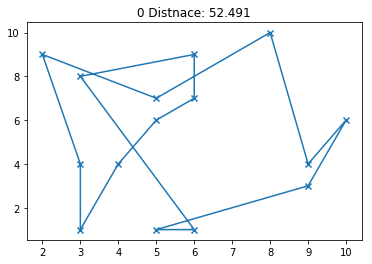

Generation 1 : Path Distance: 52.491
Generation 2 : Path Distance: 49.834
Generation 3 : Path Distance: 49.834
Generation 4 : Path Distance: 49.773
Generation 5 : Path Distance: 47.264
Generation 6 : Path Distance: 41.131
Generation 7 : Path Distance: 41.131
Generation 8 : Path Distance: 38.654
Generation 9 : Path Distance: 38.654
Generation 10 : Path Distance: 38.654


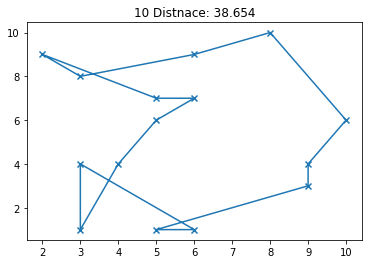

Generation 11 : Path Distance: 37.726
Generation 12 : Path Distance: 37.726
Generation 13 : Path Distance: 37.726
Generation 14 : Path Distance: 37.726
Generation 15 : Path Distance: 35.249
Generation 16 : Path Distance: 35.249
Generation 17 : Path Distance: 35.249
Generation 18 : Path Distance: 34.717
Generation 19 : Path Distance: 34.717
Generation 20 : Path Distance: 34.717


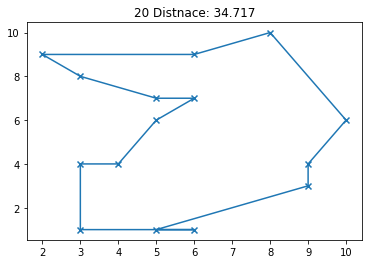

Generation 21 : Path Distance: 34.717
Generation 22 : Path Distance: 34.717
Generation 23 : Path Distance: 34.717
Generation 24 : Path Distance: 34.717
Generation 25 : Path Distance: 34.717
Generation 26 : Path Distance: 33.382
Generation 27 : Path Distance: 33.382
Generation 28 : Path Distance: 32.85
Generation 29 : Path Distance: 33.382
Generation 30 : Path Distance: 33.382


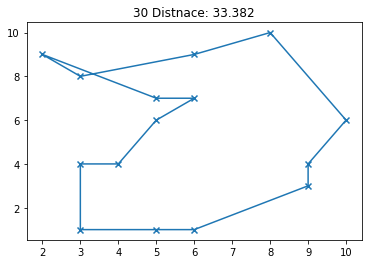

Generation 31 : Path Distance: 33.382
Generation 32 : Path Distance: 33.382
Generation 33 : Path Distance: 32.85
Generation 34 : Path Distance: 32.85
Generation 35 : Path Distance: 32.85
Generation 36 : Path Distance: 33.382
Generation 37 : Path Distance: 32.85
Generation 38 : Path Distance: 32.85
Generation 39 : Path Distance: 32.85
Generation 40 : Path Distance: 32.85


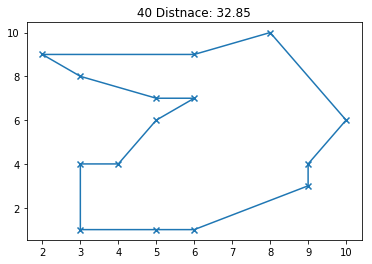

Generation 41 : Path Distance: 33.382
Generation 42 : Path Distance: 32.85
Generation 43 : Path Distance: 32.85
Generation 44 : Path Distance: 32.85
Generation 45 : Path Distance: 32.85
Generation 46 : Path Distance: 32.85
Generation 47 : Path Distance: 32.85
Generation 48 : Path Distance: 32.85
Generation 49 : Path Distance: 32.85
Generation 50 : Path Distance: 32.85


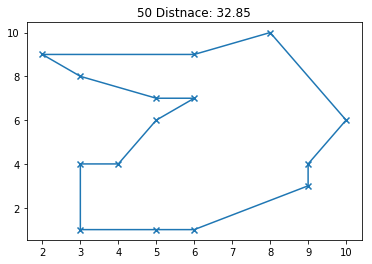

Generation 51 : Path Distance: 32.85
Generation 52 : Path Distance: 32.85
Generation 53 : Path Distance: 32.85
Generation 54 : Path Distance: 32.85
Generation 55 : Path Distance: 32.85
Generation 56 : Path Distance: 32.85
Generation 57 : Path Distance: 32.85
Generation 58 : Path Distance: 32.85
Generation 59 : Path Distance: 32.85
Generation 60 : Path Distance: 32.85


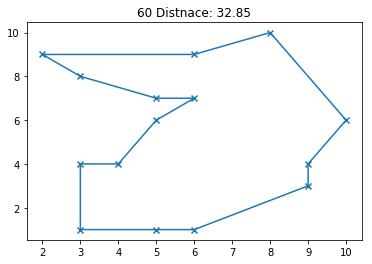

Generation 61 : Path Distance: 32.85
Generation 62 : Path Distance: 32.85
Generation 63 : Path Distance: 32.85
Generation 64 : Path Distance: 32.85
Generation 65 : Path Distance: 32.85
Generation 66 : Path Distance: 32.85
Generation 67 : Path Distance: 32.85
Generation 68 : Path Distance: 32.85
Generation 69 : Path Distance: 32.85
Generation 70 : Path Distance: 32.85


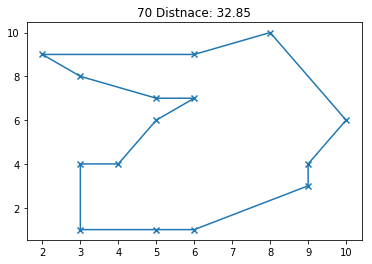

Generation 71 : Path Distance: 32.85
Generation 72 : Path Distance: 32.85
Generation 73 : Path Distance: 32.85
Generation 74 : Path Distance: 32.85
Generation 75 : Path Distance: 32.85
Generation 76 : Path Distance: 32.85
Generation 77 : Path Distance: 32.85
Generation 78 : Path Distance: 32.85
Generation 79 : Path Distance: 32.85
Generation 80 : Path Distance: 32.85


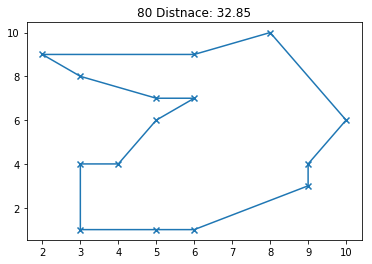

Generation 81 : Path Distance: 32.85
Generation 82 : Path Distance: 32.85
Generation 83 : Path Distance: 32.85
Generation 84 : Path Distance: 32.85
Generation 85 : Path Distance: 32.85
Generation 86 : Path Distance: 32.85
Generation 87 : Path Distance: 32.85
Generation 88 : Path Distance: 32.85
Generation 89 : Path Distance: 32.85
Generation 90 : Path Distance: 32.85


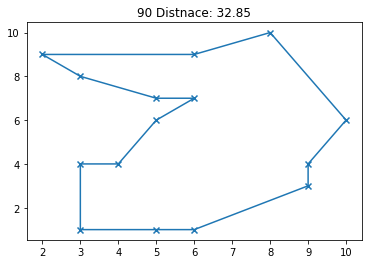

Generation 91 : Path Distance: 32.85
Generation 92 : Path Distance: 32.85
Generation 93 : Path Distance: 32.85
Generation 94 : Path Distance: 32.85
Generation 95 : Path Distance: 32.85
Generation 96 : Path Distance: 32.85
Generation 97 : Path Distance: 32.85
Generation 98 : Path Distance: 32.85
Generation 99 : Path Distance: 32.85
Generation 100 : Path Distance: 32.85


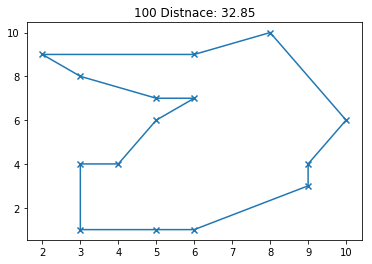

Generation 101 : Path Distance: 32.85
Generation 102 : Path Distance: 32.85
Generation 103 : Path Distance: 32.85
Generation 104 : Path Distance: 32.85
Generation 105 : Path Distance: 32.85
Generation 106 : Path Distance: 32.85
Generation 107 : Path Distance: 32.85
Generation 108 : Path Distance: 32.85
Generation 109 : Path Distance: 32.85
Generation 110 : Path Distance: 32.85


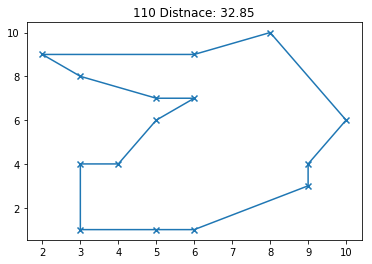

Generation 111 : Path Distance: 32.85
Generation 112 : Path Distance: 32.85
Generation 113 : Path Distance: 32.85
Generation 114 : Path Distance: 32.85
Generation 115 : Path Distance: 32.85
Generation 116 : Path Distance: 32.85
Generation 117 : Path Distance: 32.85
Generation 118 : Path Distance: 32.85
Generation 119 : Path Distance: 32.85
Generation 120 : Path Distance: 32.85


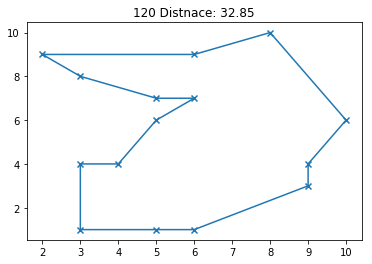

Generation 121 : Path Distance: 32.85
Generation 122 : Path Distance: 32.85
Generation 123 : Path Distance: 32.85
Generation 124 : Path Distance: 32.85
Generation 125 : Path Distance: 32.85
Generation 126 : Path Distance: 32.85
Generation 127 : Path Distance: 32.85
Generation 128 : Path Distance: 32.85
Generation 129 : Path Distance: 32.85
Generation 130 : Path Distance: 32.85


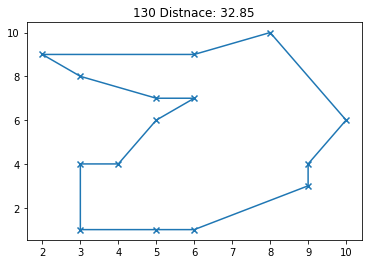

Generation 131 : Path Distance: 32.85
Generation 132 : Path Distance: 32.85
Generation 133 : Path Distance: 32.85
Generation 134 : Path Distance: 32.85
Generation 135 : Path Distance: 32.85
Generation 136 : Path Distance: 32.85
Generation 137 : Path Distance: 32.85
Generation 138 : Path Distance: 32.85
Generation 139 : Path Distance: 32.85
Generation 140 : Path Distance: 32.85


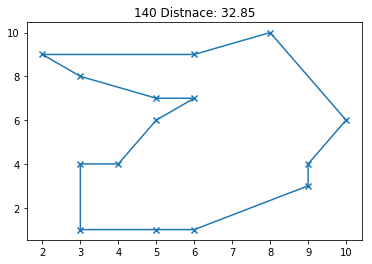

Generation 141 : Path Distance: 32.85
Generation 142 : Path Distance: 32.85
Generation 143 : Path Distance: 32.85
Generation 144 : Path Distance: 32.85
Generation 145 : Path Distance: 32.85
Generation 146 : Path Distance: 32.85
Generation 147 : Path Distance: 32.85
Generation 148 : Path Distance: 32.85
Generation 149 : Path Distance: 32.85
Generation 150 : Path Distance: 32.85


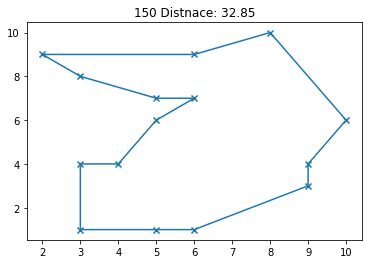

Generation 151 : Path Distance: 32.85
Generation 152 : Path Distance: 32.85
Generation 153 : Path Distance: 32.85
Generation 154 : Path Distance: 32.85
Generation 155 : Path Distance: 32.85
Generation 156 : Path Distance: 32.85
Generation 157 : Path Distance: 32.85
Generation 158 : Path Distance: 32.85
Generation 159 : Path Distance: 32.85
Generation 160 : Path Distance: 32.85


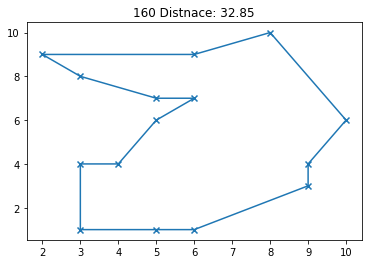

Generation 161 : Path Distance: 32.85
Generation 162 : Path Distance: 32.85
Generation 163 : Path Distance: 32.85
Generation 164 : Path Distance: 32.85
Generation 165 : Path Distance: 32.85
Generation 166 : Path Distance: 32.85
Generation 167 : Path Distance: 32.85
Generation 168 : Path Distance: 32.85
Generation 169 : Path Distance: 32.85
Generation 170 : Path Distance: 32.85


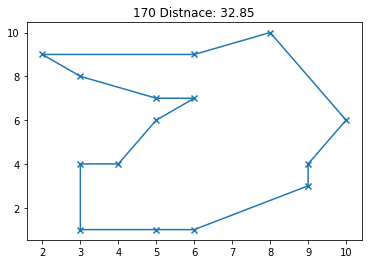

Generation 171 : Path Distance: 32.85
Generation 172 : Path Distance: 32.85
Generation 173 : Path Distance: 32.85
Generation 174 : Path Distance: 32.85
Generation 175 : Path Distance: 32.85
Generation 176 : Path Distance: 32.85
Generation 177 : Path Distance: 32.85
Generation 178 : Path Distance: 32.85
Generation 179 : Path Distance: 32.85
Generation 180 : Path Distance: 32.85


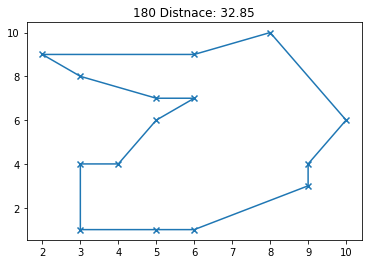

Generation 181 : Path Distance: 32.85
Generation 182 : Path Distance: 32.85
Generation 183 : Path Distance: 32.85
Generation 184 : Path Distance: 32.85
Generation 185 : Path Distance: 32.85
Generation 186 : Path Distance: 32.85
Generation 187 : Path Distance: 32.85
Generation 188 : Path Distance: 32.85
Generation 189 : Path Distance: 32.85
Generation 190 : Path Distance: 32.85


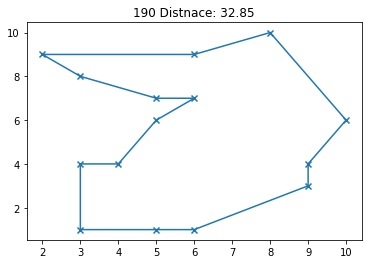

Generation 191 : Path Distance: 32.85
Generation 192 : Path Distance: 32.85
Generation 193 : Path Distance: 32.85
Generation 194 : Path Distance: 32.85
Generation 195 : Path Distance: 32.85
Generation 196 : Path Distance: 32.85
Generation 197 : Path Distance: 32.85
Generation 198 : Path Distance: 32.85
Generation 199 : Path Distance: 32.85


In [20]:
solver = GASolve(points = points, n=1000, mutation_rate=0.35)
solver.solve(generations=200)


Solution Path Distance: 32.85
[(10, 6), (8, 10), (6, 9), (2, 9), (3, 8), (5, 7), (6, 7), (5, 6), (4, 4), (3, 4), (3, 1), (5, 1), (6, 1), (9, 3), (9, 4), (10, 6)]


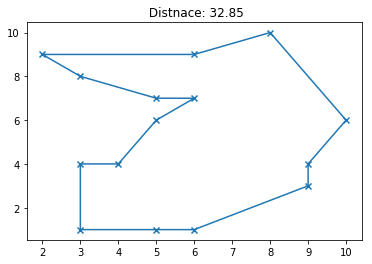

In [21]:
solution = solver.path
solution.plot()
print('Solution', solution)
print(str(solution.path))
plt.show()

## Reference:

S. Lin, ["Computer solutions of the traveling salesman problem,"](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6767727&isnumber=6767724) in The Bell System Technical Journal, vol. 44, no. 10, pp. 2245-2269, Dec. 1965.
doi: 10.1002/j.1538-7305.1965.tb04146.x
Abstract: Two algorithms for solving the (symmetric distance) traveling salesman problem have been programmed for a high-speed digital computer. The first produces guaranteed optimal solution for problems involving no more than 13 cities; the time required (IBM 7094 II) varies from 60 milliseconds for a 9-city problem to 1.75 seconds for a 13-city problem. The second algorithm produces precisely characterized, locally optimal solutions for large problems (up to 145 cities) in an extremely short time and is based on a general heuristic approach believed to be of general applicability to various optimization problems. The average time required to obtain a locally optimal solution is under 30n3 microseconds where n is the number of cities involved. Repeated runs on a problem from random initial tours result in a high probability of finding the optimal solution among the locally optimal solutions obtained. For large problems where many locally optimal solutions have to be obtained in order to be reasonably assured of having the optimal solution, an efficient reduction scheme is incorporated in the program to reduce the total computation time by a substantial amount.